In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use('default')
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap, TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, TimeDistributed, Embedding, GlobalAveragePooling1D, Flatten, SimpleRNN, GRU, Dropout, LSTM
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines()) 
import os

# Aula 20: Geração de Conteúdo
**Objetivo: ao fim desta aula, o aluno será capaz de usar redes neurais para gerar conteúdo**

In [2]:
import urllib
url = "https://www.gutenberg.org/cache/epub/3333/pg3333.txt" # Os Lusíadas (Camões)
url = "https://www.gutenberg.org/files/11/11-0.txt" #Alice in Wonderland
texto = urllib.request.urlopen(url).read().decode()[3000:-20000]
texto = texto.replace("\r\n", " ")
texto = texto.replace("“", "")
texto = texto.replace("”", "")
texto = texto.lower()
#print(texto[-1000:-1])


# Exercício 1
*Objetivo: lembrar-se de como funcionam os modelos de geração de conteúdo por n-gramas*

Analise os códigos abaixo, relacionados aos modelos clássicos de geração de conteúdo por n-gramas.

1. Em linhas gerais, como eles funcionam?
1. O que é levado em consideração (ou: o que é a "entrada") para cada geração de uma nova palavra?

In [3]:
import re
frases = re.split('[.]', texto)[4:]
tokens = [ re.findall("\w+", f) for f in frases ]
tokens = [ [w.lower() for w in f] for f in tokens]
print(tokens[0:2])


[['well', 'thought', 'alice', 'to', 'herself', 'after', 'such', 'a', 'fall', 'as', 'this', 'i', 'shall', 'think', 'nothing', 'of', 'tumbling', 'down', 'stairs', 'how', 'brave', 'they', 'll', 'all', 'think', 'me', 'at', 'home', 'why', 'i', 'wouldn', 't', 'say', 'anything', 'about', 'it', 'even', 'if', 'i', 'fell', 'off', 'the', 'top', 'of', 'the', 'house', 'which', 'was', 'very', 'likely', 'true'], ['down', 'down', 'down']]


In [4]:
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
n = 5
train_data, vocab = padded_everygram_pipeline(n, tokens)
lm = MLE(n)
lm.fit(train_data, vocab)
texto_ = lm.generate(100, random_seed=90)
texto_ = " ".join(texto_)
print(texto_)

<s> <s> <s> but she must have a prize herself you know said the mouse </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>


# Exercício 2
*Objetivo: relacionar um modelo de geração por n-gramas a um modelo de geração com rede feed-forward*

Analise a rede neural abaixo.

1. Quais são as suas entradas?
1. Quais são suas saídas?
1. Como essa ideia se relaciona ao modelo de geração por modelo linguístico do exercício 1?

In [5]:
from keras.preprocessing.text import Tokenizer
vocab_size = 2000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(frases)
sequences = tokenizer.texts_to_sequences(frases)

In [9]:
# Construindo n-gramas!
n = 10
x = []
y = []
frases_teste = 800
for f in range(frases_teste):
    frase_atual = sequences[f]
    for n_ in range(len(frase_atual)-n-1):
        x_ = frase_atual[n_:n_+n]
        y_ = [frase_atual[n_+n]]
        x.append(x_)
        y.append(y_)
print(x[0], x[1])
print(y[0], y[1])

[75, 56, 10, 3, 49, 109, 110, 4, 463, 15] [56, 10, 3, 49, 109, 110, 4, 463, 15, 28]
[28] [9]


In [10]:
# Passando minhas saidas para one-hot encoding
ohe = OneHotEncoder()
y_ohe = ohe.fit_transform(y).toarray()
print(vocab_size, y_ohe.shape)

2000 (13556, 1738)


2022-05-12 16:15:43.062154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 16:15:43.070006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 16:15:43.072286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 16:15:43.074433: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

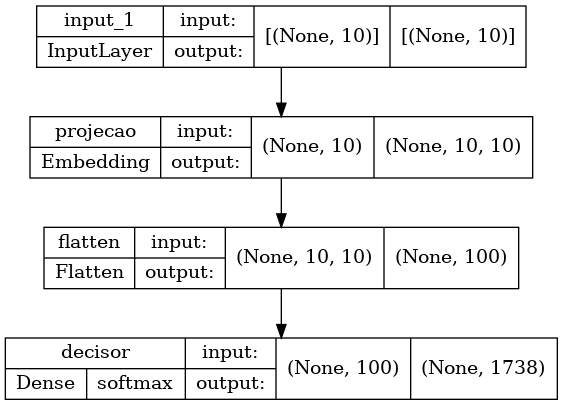

In [8]:
def rede_neural_predizer_palavras(input_dims, vocab_size, dim_latente, dim_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(vocab_size, dim_latente, name='projecao')(x)
  x = Flatten()(x)
  y = Dense(dim_out, activation='softmax', name='decisor')(x)
  return Model(input_layer, y)

rede_neural = rede_neural_predizer_palavras(n, vocab_size, 10, y_ohe.shape[1])
rede_neural.compile(optimizer='adam', loss='categorical_crossentropy')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

In [9]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(np.array(x), y_ohe, epochs=30)#, validation_split=0.2, callbacks=es)

2022-05-12 16:15:44.439251: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 94241312 exceeds 10% of free system memory.


Epoch 1/30


2022-05-12 16:15:44.761661: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 94241312 exceeds 10% of free system memory.


424/424 [==============================] - 2s 3ms/step - loss: 6.6079
Epoch 2/30
424/424 [==============================] - 1s 3ms/step - loss: 5.8831
Epoch 3/30
424/424 [==============================] - 1s 3ms/step - loss: 5.7702
Epoch 4/30
424/424 [==============================] - 1s 3ms/step - loss: 5.5930
Epoch 5/30
424/424 [==============================] - 1s 3ms/step - loss: 5.3411
Epoch 6/30
424/424 [==============================] - 1s 3ms/step - loss: 5.0226
Epoch 7/30
424/424 [==============================] - 1s 3ms/step - loss: 4.6535
Epoch 8/30
424/424 [==============================] - 1s 3ms/step - loss: 4.2678
Epoch 9/30
424/424 [==============================] - 1s 3ms/step - loss: 3.8992
Epoch 10/30
424/424 [==============================] - 1s 2ms/step - loss: 3.5664
Epoch 11/30
424/424 [==============================] - 1s 2ms/step - loss: 3.2822
Epoch 12/30
424/424 [==============================] - 1s 2ms/step - loss: 3.0484
Epoch 13/30
424/424 [===============

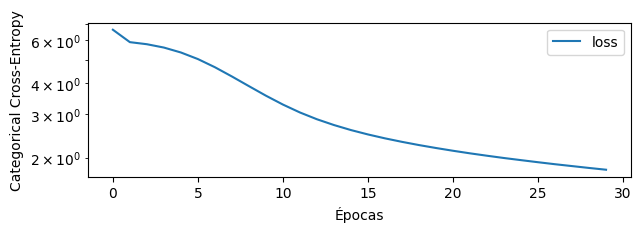

In [10]:
plt.figure(figsize=(7,2))
plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Épocas')
plt.semilogy()
plt.ylabel('Categorical Cross-Entropy')
plt.legend()
plt.show()

In [11]:
print(np.array([x[0]]))
y0 = rede_neural.predict(np.array([x[0]]))

[[ 75  56  10   3  49 109 110   4 463  15]]


In [12]:
# Prever sequencia a partir de um inicio
n_palavras = 100
seq = list(x[30])
print(tokenizer.sequences_to_texts([seq]), end='')
y_ = []
for palavra in range(n_palavras):
    y0 = rede_neural.predict(np.array([seq]))
    y0[0,0] = 0 # Proibido usar "\r" na saida
    y0_seq = ohe.inverse_transform(y0)
    #print(y0_seq)
    #print(tokenizer.sequences_to_texts(y0_seq))
    y_.append(y0_seq[0])
    print(tokenizer.sequences_to_texts([y0_seq[0]]), end='')
    seq.append(y0_seq[0][0])
    seq = seq[1:]
    #print(seq)
    
print(" ---- ")
words = tokenizer.sequences_to_texts(y_)
print(words)
texto_ = ' '.join(words)
print(texto_)


['say anything about it even if i fell off the']['top']['of']['a']['way']['of']['voices']['one']['eyes']['and']['they']['could']['much']['at']['once']['while']['a']['bit']['of']['a']['little']['golden']['key']['and']['then']['it']['was']['very']['much']['a']['sort']['of']['way']['with']['dry']['up']['to']['see']['two']['she']['had']['put']['some']['of']['hand']['and']['behind']['made']['her']['hand']['in']['her']['hands']['and']['she']['looked']['up']['to']['her']['chin']['nibbling']['because']['she']['had']['my']['else']['and']['did']['how']['was']['after']['a']['game']['in']['time']['if']['i']['never']['think']['to']['have']['got']['to']['see']['if']['i']['haven’t']['you']['been']['said']['it']['very']['like']['a']['sort']['of']['a']['words']['in']['a']['sea'] ---- 
['top', 'of', 'a', 'way', 'of', 'voices', 'one', 'eyes', 'and', 'they', 'could', 'much', 'at', 'once', 'while', 'a', 'bit', 'of', 'a', 'little', 'golden', 'key', 'and', 'then', 'it', 'was', 'very', 'much', 'a', 'sort', 'o

In [13]:
texto_ = ' '.join(words)
print(texto_)

top of a way of voices one eyes and they could much at once while a bit of a little golden key and then it was very much a sort of way with dry up to see two she had put some of hand and behind made her hand in her hands and she looked up to her chin nibbling because she had my else and did how was after a game in time if i never think to have got to see if i haven’t you been said it very like a sort of a words in a sea


# Exercício 3
*Objetivo: discutir o espaço latente gerado pela rede neural*

Visualizando o espaço latente da rede neural, você consegue verificar alguma relação entre as posições de palavras importantes do texto e seus significados?

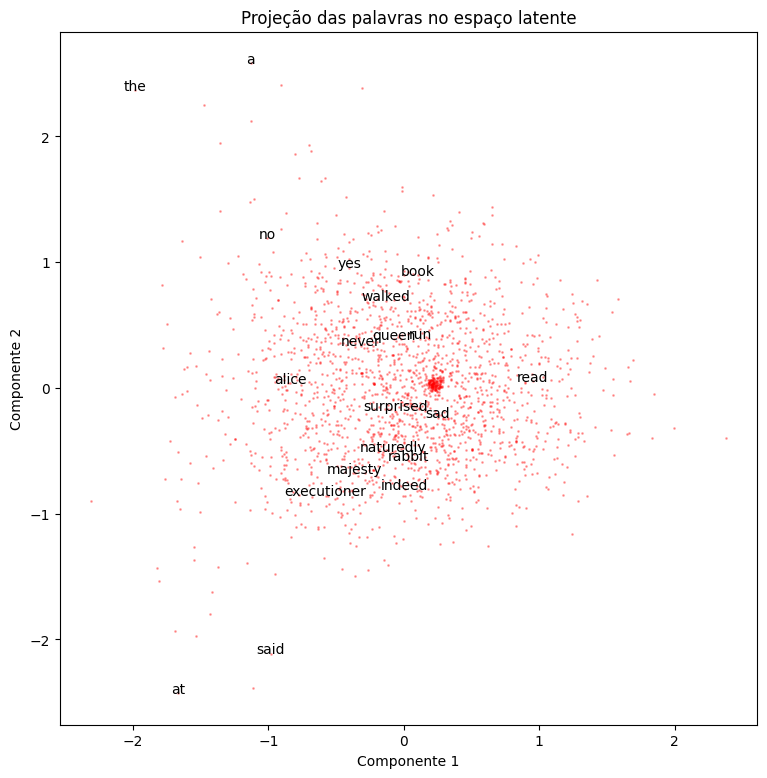

In [14]:
# Visualização: onde foi parar cada palavra?
v_ = rede_neural.get_layer('projecao').get_weights()[0]

proj = PCA(n_components=2)
v = proj.fit_transform(v_)
#v = v_

plt.figure(figsize=(9,9))
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.3, c='r')
for s in ["alice", "rabbit", "queen", "majesty", "surprised", "never", "executioner", "run", "read", "book", "walked", "said", "sad", "a", "at", "the", "yes", "no", "indeed", "naturedly"]:
    #print(s)
    _n = tokenizer.texts_to_sequences([[s]])[0][0]
    plt.text(v[_n,0], v[_n,1], s, ha='center')
plt.title('Projeção das palavras no espaço latente')
plt.ylabel('Componente 2')
plt.xlabel('Componente 1')
#plt.xlim([-0.20,0.20])
#plt.ylim([-0.20,0.20])
plt.show()

## Análise do espaço latente

In [15]:
palavras = tokenizer.word_index.keys()
print(len(palavras))

2772


### Raio das palavras no espaço latente

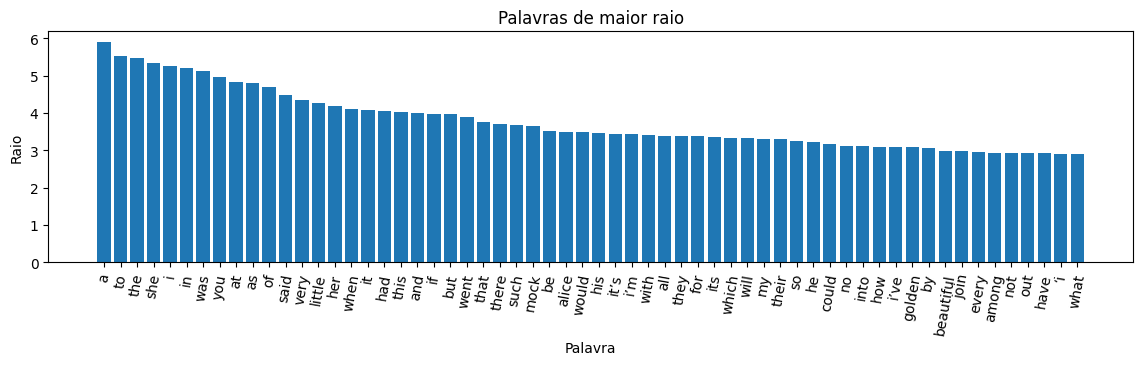

In [16]:
raios = []
for idx in range(1,2000):
    w = tokenizer.index_word[idx]
    r = np.sqrt(np.sum(v_[idx,:]**2))
    raios.append ( (r, w) )

tuplas_ordenadas = sorted(raios, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]
eixo_x = np.arange(len(palavras))
n_palavras = 60
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=80)
plt.ylabel('Raio')
plt.xlabel('Palavra')
plt.title('Palavras de maior raio')
plt.show()

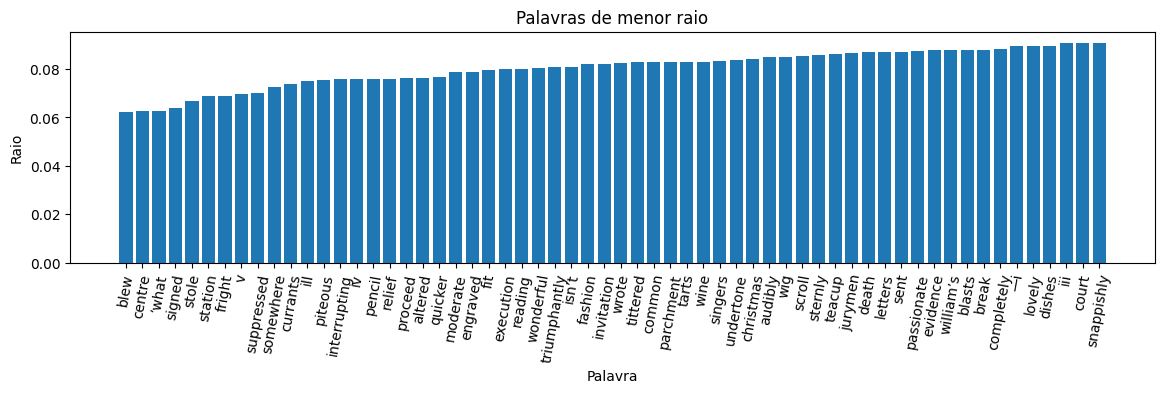

In [17]:
raios = []
for idx in range(1,2000):
    w = tokenizer.index_word[idx]
    r = np.sqrt(np.sum(v_[idx,:]**2))
    raios.append ( (r, w) )

tuplas_ordenadas = sorted(raios) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]
eixo_x = np.arange(len(palavras))
n_palavras = 60
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=80)
plt.ylabel('Raio')
plt.xlabel('Palavra')
plt.title('Palavras de menor raio')
plt.show()

### Palavras mais próximas de "Alice"

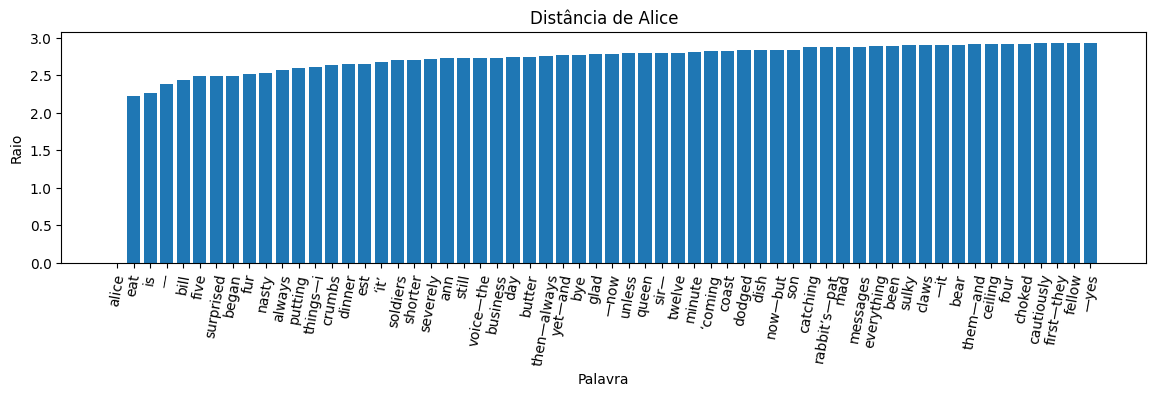

In [18]:
alice_idx = tokenizer.word_index['alice']

raios = []
for idx in range(1,2000):
    w = tokenizer.index_word[idx]
    r = np.sqrt(np.sum( (v_[idx,:]-v_[alice_idx,:])**2))
    raios.append ( (r, w) )

tuplas_ordenadas = sorted(raios) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]
eixo_x = np.arange(len(palavras))
n_palavras = 60
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=80)
plt.ylabel('Raio')
plt.xlabel('Palavra')
plt.title('Distância de Alice')
plt.show()

# Modelo: rede neural recorrente

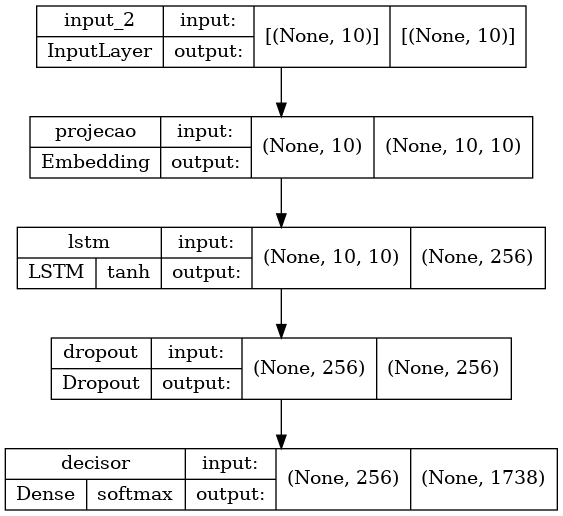

In [19]:
def rede_neural_predizer_palavras(input_dims, vocab_size, dim_latente, dim_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(vocab_size, dim_latente, name='projecao')(x)
  # x = LSTM(256, return_sequences=True)(x)
  # x = Dropout(0.2)(x)
  x = LSTM(256)(x)
  x = Dropout(0.2)(x)
  y = Dense(dim_out, activation='softmax', name='decisor')(x)
  return Model(input_layer, y)

rede_neural = rede_neural_predizer_palavras(n, vocab_size, 10, y_ohe.shape[1])
rede_neural.compile(optimizer='adam', loss='categorical_crossentropy')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

In [20]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(np.array(x), y_ohe, epochs=60)#, validation_split=0.2, callbacks=es)

Epoch 1/60


2022-05-12 16:16:25.033878: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 94241312 exceeds 10% of free system memory.
2022-05-12 16:16:25.147933: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 94241312 exceeds 10% of free system memory.
2022-05-12 16:16:29.878188: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


424/424 [==============================] - 9s 4ms/step - loss: 6.1549
Epoch 2/60
424/424 [==============================] - 2s 4ms/step - loss: 5.8328
Epoch 3/60
424/424 [==============================] - 2s 4ms/step - loss: 5.7089
Epoch 4/60
424/424 [==============================] - 2s 4ms/step - loss: 5.5706
Epoch 5/60
424/424 [==============================] - 2s 4ms/step - loss: 5.4545
Epoch 6/60
424/424 [==============================] - 2s 4ms/step - loss: 5.3387
Epoch 7/60
424/424 [==============================] - 2s 4ms/step - loss: 5.2165
Epoch 8/60
424/424 [==============================] - 2s 4ms/step - loss: 5.0813
Epoch 9/60
424/424 [==============================] - 2s 4ms/step - loss: 4.9222
Epoch 10/60
424/424 [==============================] - 2s 4ms/step - loss: 4.7503
Epoch 11/60
424/424 [==============================] - 2s 4ms/step - loss: 4.5501
Epoch 12/60
424/424 [==============================] - 2s 4ms/step - loss: 4.3449
Epoch 13/60
424/424 [===============

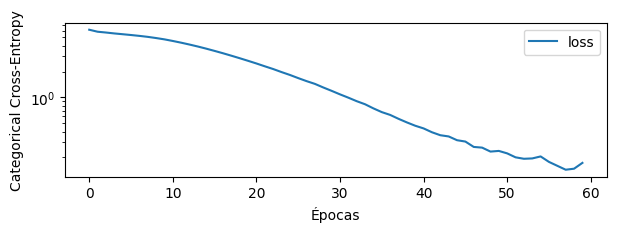

In [21]:
plt.figure(figsize=(7,2))
plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Épocas')
plt.semilogy()
plt.ylabel('Categorical Cross-Entropy')
plt.legend()
plt.show()

In [22]:
# Prever sequencia a partir de um inicio
n_palavras = 100
seq = list(x[30])
print(tokenizer.sequences_to_texts([seq]), end='')
y_ = []
for palavra in range(n_palavras):
    y0 = rede_neural.predict(np.array([seq]))
    y0[0,0] = 0 # Proibido usar "\r" na saida
    y0_seq = ohe.inverse_transform(y0)
    #print(y0_seq)
    #print(tokenizer.sequences_to_texts(y0_seq))
    y_.append(y0_seq[0])
    print(tokenizer.sequences_to_texts([y0_seq[0]]), end='')
    seq.append(y0_seq[0][0])
    seq = seq[1:]
    #print(seq)
    
print(" ---- ")
words = tokenizer.sequences_to_texts(y_)
print(words)
texto_ = ' '.join(words)
print(texto_)

['say anything about it even if i fell off the']['top']['of']['a']['house']['which']['was']['just']['at']['her']['dear']['hard']['when']['to']['make']['that']['she']['had']['remember']['no']['more']['to']['hint']['you']['had']['see']['why']['out']['i']['throw']['them']['and']['it']['at']['its']['few']['ear']['and']['left']['on']['begins']['with']['its']['hands']['and']['so']['like']['her']['stretching']['with']['she']['was']['not']['herself']['anything']['so']['that']['back']['she']['was']['if']['it']['put']['a']['large']['bottle']['though']['i']['are']['painting']['she']['had']['removed']['it']['all']['it']['said']['a']['cry']['of']['its']['ears']['and']['whiskers']['like']['that']['my']['dear']['and']['feet']['for']['her']['head']['when']['once']['in']['a']['little']['tone']['in']['a'] ---- 
['top', 'of', 'a', 'house', 'which', 'was', 'just', 'at', 'her', 'dear', 'hard', 'when', 'to', 'make', 'that', 'she', 'had', 'remember', 'no', 'more', 'to', 'hint', 'you', 'had', 'see', 'why', 'o

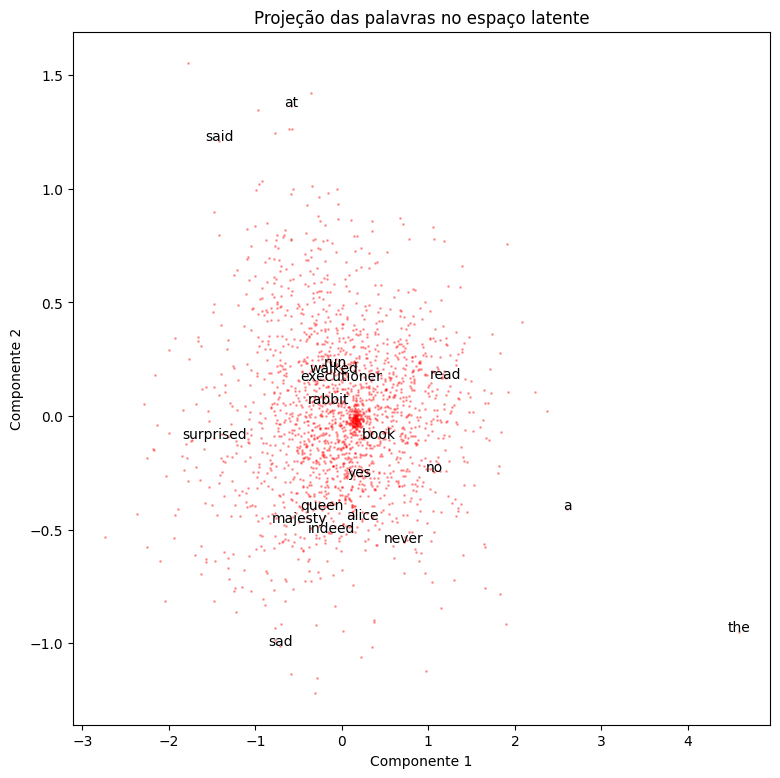

In [23]:
# Visualização: onde foi parar cada palavra?
v_ = rede_neural.get_layer('projecao').get_weights()[0]

proj = PCA(n_components=2)
v = proj.fit_transform(v_)
#v = v_

plt.figure(figsize=(9,9))
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.3, c='r')
for s in ["alice", "rabbit", "queen", "majesty", "surprised", "never", "executioner", "run", "read", "book", "walked", "said", "sad", "a", "at", "the", "yes", "no", "indeed"]:
    #print(s)
    _n = tokenizer.texts_to_sequences([[s]])[0][0]
    plt.text(v[_n,0], v[_n,1], s, ha='center')
plt.title('Projeção das palavras no espaço latente')
plt.ylabel('Componente 2')
plt.xlabel('Componente 1')
#plt.xlim([-0.20,0.20])
#plt.ylim([-0.20,0.20])
plt.show()

## Análise do espaço latente

In [24]:
palavras = tokenizer.word_index.keys()
print(len(palavras))

2772


### Raio das palavras no espaço latente

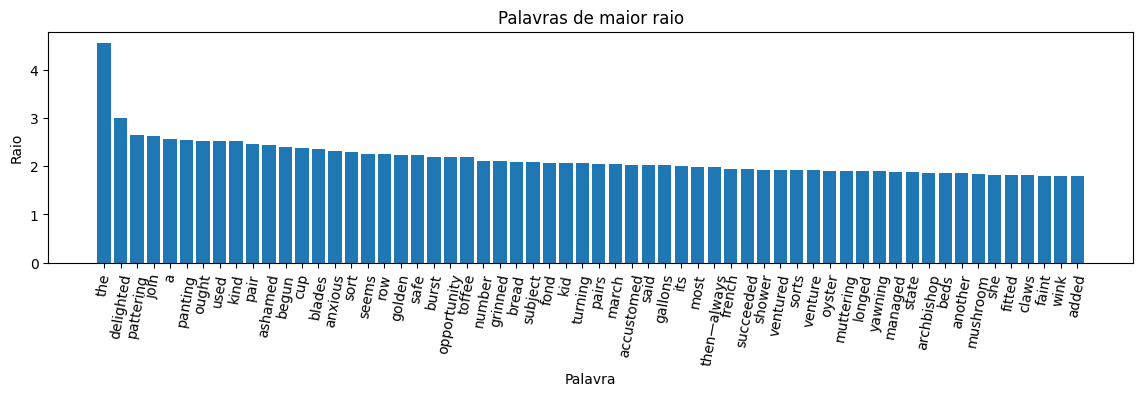

In [25]:
raios = []
for idx in range(1,2000):
    w = tokenizer.index_word[idx]
    r = np.sqrt(np.sum(v_[idx,:]**2))
    raios.append ( (r, w) )

tuplas_ordenadas = sorted(raios, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]
eixo_x = np.arange(len(palavras))
n_palavras = 60
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=80)
plt.ylabel('Raio')
plt.xlabel('Palavra')
plt.title('Palavras de maior raio')
plt.show()

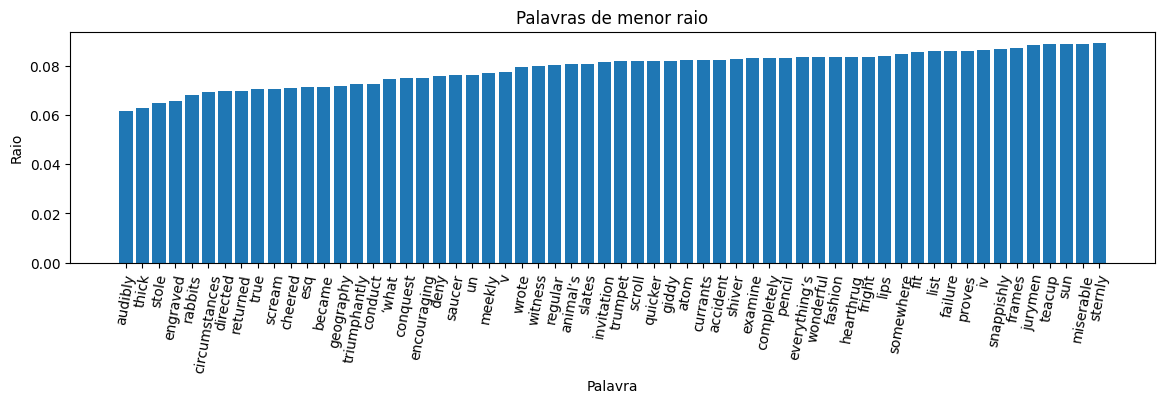

In [26]:
raios = []
for idx in range(1,2000):
    w = tokenizer.index_word[idx]
    r = np.sqrt(np.sum(v_[idx,:]**2))
    raios.append ( (r, w) )

tuplas_ordenadas = sorted(raios) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]
eixo_x = np.arange(len(palavras))
n_palavras = 60
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=80)
plt.ylabel('Raio')
plt.xlabel('Palavra')
plt.title('Palavras de menor raio')
plt.show()

### Palavras mais próximas de "Alice"

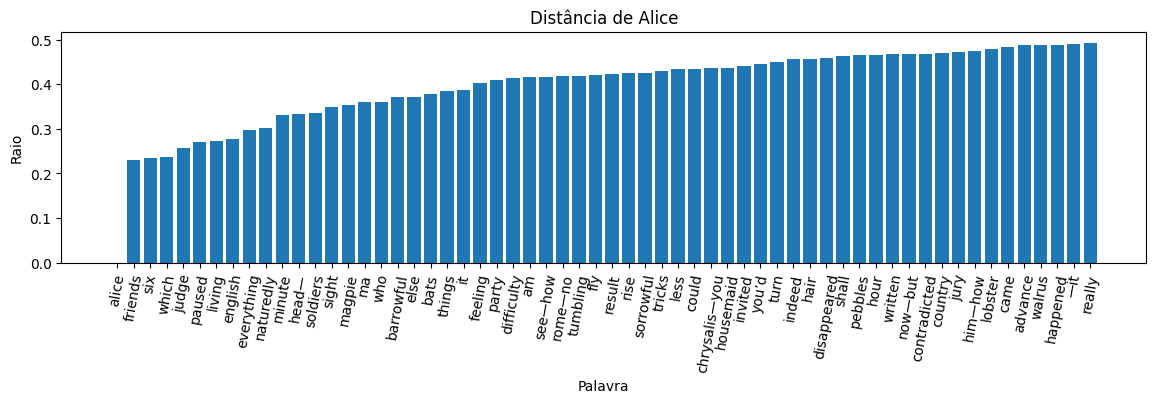

In [27]:
alice_idx = tokenizer.word_index['alice']

raios = []
for idx in range(1,2000):
    w = tokenizer.index_word[idx]
    r = np.sqrt(np.sum( (v_[idx,:]-v_[alice_idx,:])**2))
    raios.append ( (r, w) )

tuplas_ordenadas = sorted(raios) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]
eixo_x = np.arange(len(palavras))
n_palavras = 60
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=80)
plt.ylabel('Raio')
plt.xlabel('Palavra')
plt.title('Distância de Alice')
plt.show()

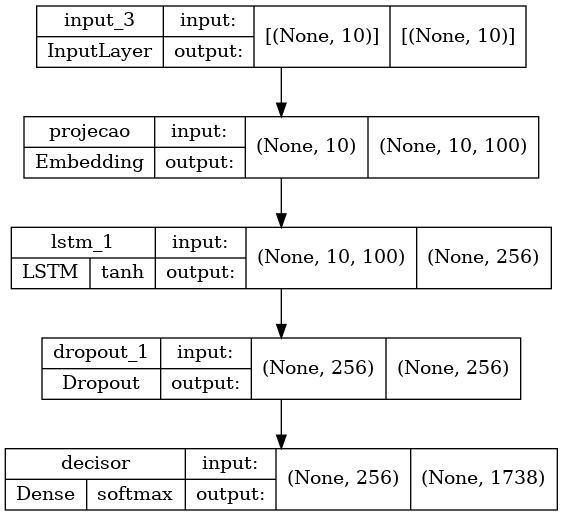

In [11]:
f = open("./datasets/glove.6B.100d.txt", encoding="utf8")
embeddings_index = dict()
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        continue
f.close()

# Reconstruindo a matriz de embeddings (para carregar na camada embedding)
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

from keras.layers import SimpleRNN
def rede_neural_com_Glove(input_dims, n_dims_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(len(word_index) + 1, 100, name='projecao', weights=[embedding_matrix], trainable=False)(x)
  x = LSTM(256)(x)
  x = Dropout(0.2)(x)
  y = Dense(n_dims_out, activation='softmax', name='decisor')(x)
  return Model(input_layer, y)
  
# n, vocab_size, 10, y_ohe.shape[1]
rede_neural = rede_neural_com_Glove(10, y_ohe.shape[1])
rede_neural.compile(optimizer='adam', loss='mse')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

In [12]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(np.array(x), y_ohe, epochs=60)

Epoch 1/60


2022-05-17 18:18:47.676510: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


424/424 [==============================] - 9s 4ms/step - loss: 5.7499e-04
Epoch 2/60
424/424 [==============================] - 1s 3ms/step - loss: 5.7199e-04
Epoch 3/60
424/424 [==============================] - 1s 3ms/step - loss: 5.6850e-04
Epoch 4/60
424/424 [==============================] - 1s 3ms/step - loss: 5.6655e-04
Epoch 5/60
424/424 [==============================] - 1s 3ms/step - loss: 5.6554e-04
Epoch 6/60
424/424 [==============================] - 1s 3ms/step - loss: 5.6440e-04
Epoch 7/60
424/424 [==============================] - 1s 3ms/step - loss: 5.6320e-04
Epoch 8/60
424/424 [==============================] - 1s 3ms/step - loss: 5.6136e-04
Epoch 9/60
424/424 [==============================] - 1s 4ms/step - loss: 5.6044e-04
Epoch 10/60
424/424 [==============================] - 1s 3ms/step - loss: 5.5891e-04
Epoch 11/60
424/424 [==============================] - 1s 3ms/step - loss: 5.5763e-04
Epoch 12/60
424/424 [==============================] - 1s 3ms/step - loss:

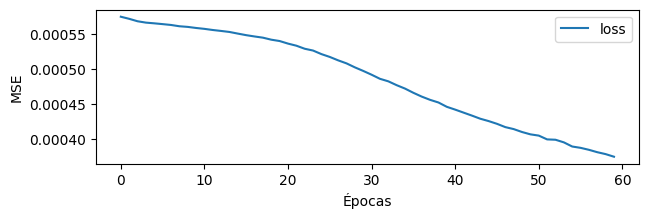

In [13]:
plt.figure(figsize=(7,2))
plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [17]:
# Prever sequencia a partir de um inicio
n_palavras = 30
seq = list(x[n_palavras])
print(tokenizer.sequences_to_texts([seq]), end='')
y_ = []
for palavra in range(n_palavras):
    y0 = rede_neural.predict(np.array([seq]))
    y0[0,0] = 0 # Proibido usar "\r" na saida
    y0_seq = ohe.inverse_transform(y0)
    #print(y0_seq)
    #print(tokenizer.sequences_to_texts(y0_seq))
    y_.append(y0_seq[0])
    print(tokenizer.sequences_to_texts([y0_seq[0]]), end='')
    seq.append(y0_seq[0][0])
    seq = seq[1:]
    #print(seq)
    
print(" ---- ")
words = tokenizer.sequences_to_texts(y_)
print(words)
texto_ = ' '.join(words)
print(texto_)

['say anything about it even if i fell off the']['same']['thing']['how']['what']['is']['might']['a']['good']['thing']['for']['me']['for']['this']['thing']['said']['alice']['to']['herself']['as']['she']['could']['got']['out']['of']['a']['little']['way']['think']['what']['would'] ---- 
['same', 'thing', 'how', 'what', 'is', 'might', 'a', 'good', 'thing', 'for', 'me', 'for', 'this', 'thing', 'said', 'alice', 'to', 'herself', 'as', 'she', 'could', 'got', 'out', 'of', 'a', 'little', 'way', 'think', 'what', 'would']
same thing how what is might a good thing for me for this thing said alice to herself as she could got out of a little way think what would
